In [72]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from keras import ops
from keras import layers
from keras import regularizers
from sklearn.ensemble import RandomForestClassifier
import warnings

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset
The dataset I have chosen is a Lung Cancer Prediction dataset. It has 25 features with the target variable being a prediction of whether or not a person has or is at risk for lung cancer. This is a classification problem. There are a lot of features of different types and there are over 400,000 data points, making this dataset more complex, which will allow more testing for the data. The datset is from kaggle and is linked below.
https://www.kaggle.com/datasets/ankushpanday1/lung-cancer-risk-and-prediction-dataset/data

In [74]:
data_path = "/content/drive/My Drive/Projects in AI and ML/hw3/lung_cancer_prediction.csv"
df = pd.read_csv(data_path)

In [75]:
df.head()

,Country,Age,Gender,Smoking_Status,Second_Hand_Smoke,Air_Pollution_Exposure,Occupation_Exposure,Rural_or_Urban,Socioeconomic_Status,Healthcare_Access,...,Treatment_Access,Clinical_Trial_Access,Language_Barrier,Mortality_Risk,5_Year_Survival_Probability,Delay_in_Diagnosis,Family_History,Indoor_Smoke_Exposure,Tobacco_Marketing_Exposure,Final_Prediction
0,Russia,82,Male,Former Smoker,Yes,Medium,No,Urban,High,Limited,...,Partial,Yes,No,0.263278,0.797576,Yes,No,No,No,No
1,Thailand,66,Female,Former Smoker,No,High,No,Rural,Middle,Good,...,Partial,Yes,No,0.154697,0.336674,Yes,No,No,Yes,No
2,Colombia,87,Male,Former Smoker,No,Medium,No,Urban,Low,Poor,...,Partial,Yes,No,0.607435,0.063621,No,No,No,Yes,No
3,Egypt,51,Female,Former Smoker,No,Low,Yes,Rural,High,Good,...,Full,No,No,0.081184,0.336814,No,No,No,Yes,No
4,DR Congo,43,Male,Former Smoker,No,High,No,Urban,Middle,Good,...,Full,No,No,0.643276,0.820103,No,No,No,No,No


# Perform Exploratory Data Analysis
I am doing this step up here so that I can use the cleaned data to test the my Neural Network implementation below.

In [76]:
df.isna().sum() # check for missing data points

,0
Country,0
Age,0
Gender,0
Smoking_Status,0
Second_Hand_Smoke,0
Air_Pollution_Exposure,0
Occupation_Exposure,0
Rural_or_Urban,0
Socioeconomic_Status,0
Healthcare_Access,0


There are two attributes that have missing datasets. Neither are numeric, so I will replace the missing values with the most frequent values.

In [77]:
# handle missing data
imputer = SimpleImputer(strategy='most_frequent')

df[['Mutation_Type']] = imputer.fit_transform(df[['Mutation_Type']])
df[['Treatment_Access']] = imputer.fit_transform(df[['Treatment_Access']])

df[['Mutation_Type', 'Treatment_Access']] = pd.DataFrame(
    imputer.fit_transform(df[['Mutation_Type', 'Treatment_Access']]),
    columns=['Mutation_Type', 'Treatment_Access']
)
df.isnull().sum()

,0
Country,0
Age,0
Gender,0
Smoking_Status,0
Second_Hand_Smoke,0
Air_Pollution_Exposure,0
Occupation_Exposure,0
Rural_or_Urban,0
Socioeconomic_Status,0
Healthcare_Access,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460292 entries, 0 to 460291
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Country                      460292 non-null  object 
 1   Age                          460292 non-null  int64  
 2   Gender                       460292 non-null  object 
 3   Smoking_Status               460292 non-null  object 
 4   Second_Hand_Smoke            460292 non-null  object 
 5   Air_Pollution_Exposure       460292 non-null  object 
 6   Occupation_Exposure          460292 non-null  object 
 7   Rural_or_Urban               460292 non-null  object 
 8   Socioeconomic_Status         460292 non-null  object 
 9   Healthcare_Access            460292 non-null  object 
 10  Insurance_Coverage           460292 non-null  object 
 11  Screening_Availability       460292 non-null  object 
 12  Stage_at_Diagnosis           460292 non-null  object 
 13 

In [79]:
df.describe()

,Age,Mortality_Risk,5_Year_Survival_Probability
count,460292.000000,460292.000000,460292.000000
mean,60.044183,0.500113,0.499866
std,17.590029,0.259828,0.260258
min,30.000000,0.050002,0.050001
25%,45.000000,0.274948,0.274252
50%,60.000000,0.500361,0.499002
75%,75.000000,0.725412,0.726071
max,90.000000,0.949997,0.949998


In [80]:
df.nunique()

,0
Country,30
Age,61
Gender,2
Smoking_Status,3
Second_Hand_Smoke,2
Air_Pollution_Exposure,3
Occupation_Exposure,2
Rural_or_Urban,2
Socioeconomic_Status,3
Healthcare_Access,3


In [81]:
label_encoder = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [82]:
# Perform EDA and use VIF

# Calculate VIF for each feature
X = df.drop('Final_Prediction', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

# Determine features with high VIF
high_vif_features = vif_data[vif_data["VIF"] > 5]["feature"].tolist()

# Deal with multicollinearity
if high_vif_features:
    print("\nFeatures with high VIF:")
    print(high_vif_features)
    # Remove features with high VIF
    for feature in high_vif_features:
      X = X.drop(feature, axis = 1)
      vif_data = pd.DataFrame()
      vif_data["feature"] = X.columns
      vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
      print("\nVIF after removing", feature)
      print(vif_data)
      high_vif_features = vif_data[vif_data["VIF"] > 5]["feature"].tolist()
      if not high_vif_features:
        break
else:
    print("\nNo features with high VIF found.")

                        feature       VIF
0                       Country  3.573198
1                           Age  9.419677
2                        Gender  1.956898
3                Smoking_Status  2.424462
4             Second_Hand_Smoke  1.415758
5        Air_Pollution_Exposure  3.376725
6           Occupation_Exposure  1.323668
7                Rural_or_Urban  3.162706
8          Socioeconomic_Status  3.543655
9             Healthcare_Access  1.770424
10           Insurance_Coverage  3.176902
11       Screening_Availability  2.418514
12           Stage_at_Diagnosis  2.991215
13                  Cancer_Type  1.172954
14                Mutation_Type  3.307745
15             Treatment_Access  1.413806
16        Clinical_Trial_Access  1.242850
17             Language_Barrier  1.108738
18               Mortality_Risk  4.318405
19  5_Year_Survival_Probability  4.308349
20           Delay_in_Diagnosis  1.415839
21               Family_History  1.243044
22        Indoor_Smoke_Exposure  1

<function matplotlib.pyplot.show(close=None, block=None)>

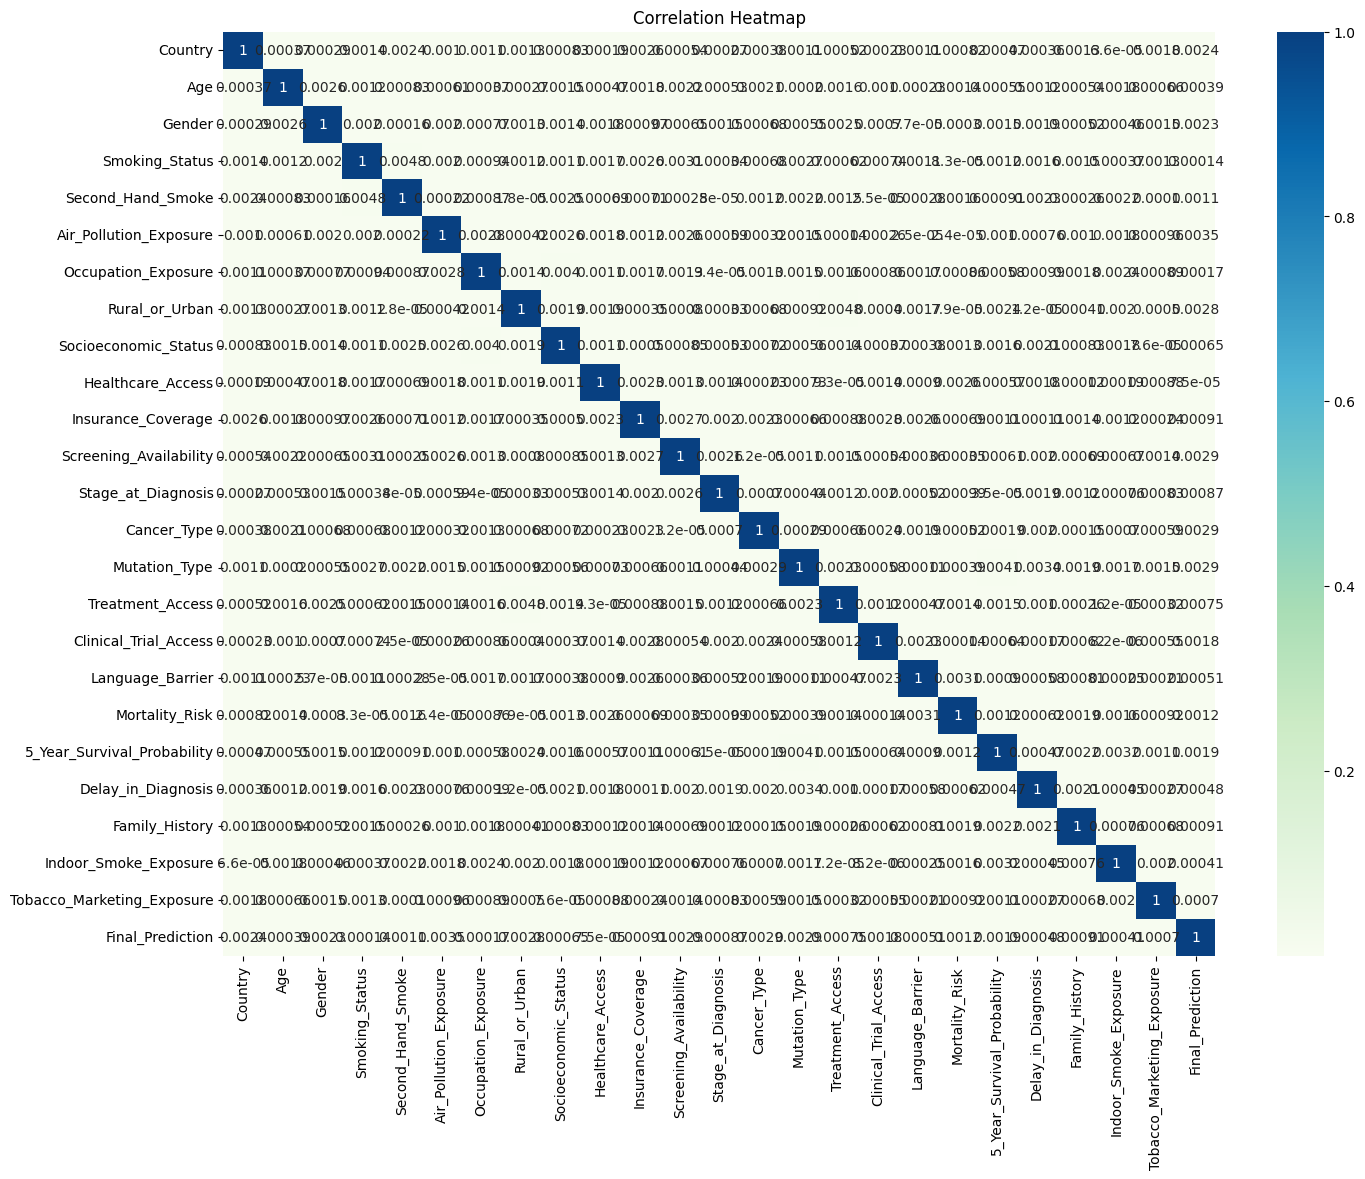

In [55]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(numeric_only=True).abs(), annot=True, cmap='GnBu')
plt.title('Correlation Heatmap')
plt.show

In [56]:
import numpy as np
class NeuralNetwork:
    # Initialization method
    def __init__(self, layers, learning_rate=0.01, batch_size=32):
        self.layers = layers
        self.learning_rate = learning_rate
        self.batch_size = batch_size  # Mini-batch size
        self.weights = []
        self.biases = []

        # Initialize weights and biases
        for i in range(len(layers) - 1):
            self.weights.append(np.random.randn(layers[i + 1], layers[i]))
            self.biases.append(np.random.randn(layers[i + 1], 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_propagation(self, inputs):
        activations = [inputs]
        for i in range(len(self.weights)):
            z = np.dot(self.weights[i], activations[-1]) + self.biases[i]
            a = self.sigmoid(z)
            activations.append(a)
        return activations

    def backward_propagation(self, activations, y):
        m = y.shape[1]
        delta = activations[-1] - y
        dWs = []
        dbs = []
        for i in reversed(range(len(self.weights))):
            dW = (1/m) * np.dot(delta, activations[i].T)
            db = (1/m) * np.sum(delta, axis=1, keepdims=True)
            dWs.insert(0, dW)
            dbs.insert(0, db)

            if i > 0:
                delta = np.dot(self.weights[i].T, delta) * self.sigmoid_derivative(activations[i])
        return dWs, dbs

    def train(self, X, y, epochs=1000):
        m = y.shape[1]
        for epoch in range(epochs):
            # using mini batch gradient descent
            for i in range(0, m, self.batch_size):
                X_batch = X[:, i:i + self.batch_size]
                y_batch = y[:, i:i + self.batch_size]

                activations = self.forward_propagation(X_batch)
                dWs, dbs = self.backward_propagation(activations, y_batch)

                # Update weights and biases
                for j in range(len(self.weights)):
                    self.weights[j] -= self.learning_rate * dWs[j]
                    self.biases[j] -= self.learning_rate * dbs[j]
            if epoch % 100 == 0:
                activations = self.forward_propagation(X)  # Calculate cost on the whole dataset
                cost = self.cost(activations[-1], y)
                print(f'Epoch: {epoch}, Cost: {cost}')

    def cost(self, predictions, y):
        m = y.shape[1]
        cost = -(1/m) * np.sum(y*np.log(predictions) + (1-y)*np.log(1-predictions))
        return cost

    def predict(self, X):
        activations = self.forward_propagation(X)
        return (activations[-1] > 0.5).astype(int)


In [57]:
# Feature scaling
scaler = MinMaxScaler()
numerical_cols = df.select_dtypes(include=np.number).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Separate features (X) and target variable (y)
X = df.drop('Final_Prediction', axis=1).values
y = df['Final_Prediction'].values.reshape(-1,1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y to (1, number of samples)
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1,-1)

# Transpose the feature matrices
X_train = X_train.T
X_test = X_test.T


# Initialize and train neural network with Mini-batch Gradient Descent
nn = NeuralNetwork(layers=[X_train.shape[0], 16, 8, 1], learning_rate=0.01)

# Only use a subset of the data to test faster
subset_size = 10000  # Adjust the subset size as needed
X_train_subset = X_train[:, :subset_size]
y_train_subset = y_train[:, :subset_size]

# Mini-batch Gradient Descent Parameters
batch_size = 32
num_batches = X_train_subset.shape[1] // batch_size

nn.train(X_train_subset, y_train_subset, epochs=200) #reduce epochs for faster testing

y_pred = nn.predict(X_test)

accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision_score(y_test.flatten(), y_pred.flatten(), average='micro')}")  # Use 'micro' averaging
print(f"Recall: {recall_score(y_test.flatten(), y_pred.flatten(), average='micro')}")  # Use 'micro' averaging
print(f"F1 Score: {f1_score(y_test.flatten(), y_pred.flatten(), average='micro')}")  # Use 'micro' averaging
# using 'micro' averaging because it is an imbalanced dataset


Epoch: 0, Cost: 0.5052110939413027
Epoch: 100, Cost: 0.5027217115113628
Accuracy: 0.80055182002846
Precision: 0.80055182002846
Recall: 0.80055182002846
F1 Score: 0.80055182002846


I chose to use Minibatch gradient descent for this model. Minibatch takes the best of both worlds between Stochastic and Batch gradient descent. In batch gradient descent, all points are used, which would be inefficient for a large dataset like this one. However, with Stochastic it only uses one point at each iteration, so it may not be as accurate. For this reason, I chose to use Minibatch Gradient descent.  

Additionally, I used a sigmoid function because that is generally a good function to use when doing a binary classification problem like this.

The Neural Network I implemented produced decent results with metrics around 0.80. The cost is not super low but not too high either, so thi suggests the model is not too bad.

## Implement a 2-layer Neural Network using a Deep Learning Framework like TensorFlow

For this implementation, I am using the keras API from TensorFlow. Keras allows me to create multiple layers and select certain activation functions at each layer. I used this to gain an overview understanding of keras: https://www.tensorflow.org/guide/keras  
In particular, I will use the Sequential function in keras (described here https://www.tensorflow.org/guide/keras/sequential_model). The Sequential model is used when there is an input tensor and an output tensor for each layer. Using the Dense function allows me to select an activation function for each layer of the Neural Network.
https://keras.io/api/layers/core_layers/dense/

## Exploratory Data Analysis was done at the beginning of this notebook on the dataset.

In [65]:
# Define the neural network model using Keras using Adam optimizer and regularization
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[0],), kernel_regularizer=regularizers.L1(0.01),
                     activity_regularizer=regularizers.L2(0.01)),  # Input layer
    keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L1(0.01),
                     activity_regularizer=regularizers.L2(0.01))  # Output layer (sigmoid for binary classification)
])

# Compile the model
model.compile(optimizer='adam',  # Use Adam optimizer
              loss='binary_crossentropy',  # Binary cross-entropy loss function
              metrics=['accuracy'])

# Train the model
model.fit(X_train.T, y_train.flatten(), epochs=10, batch_size=32, validation_split=0.1)  # Use validation split

# Evaluate the model
y_pred_prob = model.predict(X_test.T)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
precision = precision_score(y_test.flatten(), y_pred.flatten(), zero_division=1, average='micro')
recall = recall_score(y_test.flatten(), y_pred.flatten(), zero_division=1, average='micro')
f1 = f1_score(y_test.flatten(), y_pred.flatten(), zero_division=1, average='micro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10357/10357 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7995 - loss: 0.6720 - val_accuracy: 0.7980 - val_loss: 0.5154
Epoch 2/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7998 - loss: 0.5128 - val_accuracy: 0.7980 - val_loss: 0.5154
Epoch 3/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.7994 - loss: 0.5134 - val_accuracy: 0.7980 - val_loss: 0.5156
Epoch 4/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.8002 - loss: 0.5123 - val_accuracy: 0.7980 - val_loss: 0.5154
Epoch 5/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7993 - loss: 0.5136 - val_accuracy: 0.7980 - val_loss: 0.5155
Epoch 6/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.7997 - loss: 0.5130 - val_accuracy: 0.7980 - val_loss: 0.5155
Epoch 7/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.7993 - loss: 0.5136 - val_accuracy: 0.7980 - val_loss: 0.5154
Epoch 8/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7996 - lo

In [60]:
# Do it again using a different optimizer and no regularization
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[0],)),  # Input layer
    keras.layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
])

# Compile the model
model.compile(optimizer='RMSProp',  # Use RMSProp optimizer
              loss='binary_crossentropy',  # Binary cross-entropy loss function
              metrics=['accuracy'])

# Train the model
model.fit(X_train.T, y_train.flatten(), epochs=10, batch_size=32, validation_split=0.1)  # Use validation split

# Evaluate the model
y_pred_prob = model.predict(X_test.T)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
precision = precision_score(y_test.flatten(), y_pred.flatten(), zero_division=1, average='micro')
recall = recall_score(y_test.flatten(), y_pred.flatten(), zero_division=1, average='micro')
f1 = f1_score(y_test.flatten(), y_pred.flatten(), zero_division=1, average='micro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7912 - loss: 0.5101 - val_accuracy: 0.7980 - val_loss: 0.5039
Epoch 2/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8008 - loss: 0.5002 - val_accuracy: 0.7980 - val_loss: 0.5047
Epoch 3/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.8007 - loss: 0.5001 - val_accuracy: 0.7980 - val_loss: 0.5035
Epoch 4/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.8000 - loss: 0.5010 - val_accuracy: 0.7980 - val_loss: 0.5034
Epoch 5/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.8005 - loss: 0.5003 - val_accuracy: 0.7980 - val_loss: 0.5033
Epoch 6/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8003 - loss: 0.5005 - val_accuracy: 0.7980 - val_loss: 0.5034
Epoch 7/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.8001 - loss: 0.5008 - val_accuracy: 0.7980 - val_loss: 0.5033
Epoch 8/10
10357/10357 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 

In the implementation above, I used the Adam and RMSProp optimizers and binary cross entropy loss. The keras API creates two layers to be used in the Neural Network (input layer and output layer). For the input layer, I used a ReLU activation function, and for the output layer I used a sigmoid activation function since the problem is for binary classification. The model performs fairly well with metrics around 0.80.

Hyperparamter selection was done through experimentation and using Keras. For the layers, learning rate, and epochs were chosen manually through testing and were found to produce decent results. I tested the code with two different optimizers: Adam and RMSProp. Adam is an overall good optimizer that generally performs well. I also chose to test the code with RMSProp, which uses slightly different update parameters than Adam. I found that they both produced similar results. I used binary cross entropy loss because it is typically suitable for binary classification problems, which this problem is. Overall, I used keras because it helped simpllify the process and consolodate everything. I used the L1 regularization method to help reduce overfitting and improve the model. The results did not significantly differ when I added regularization.


In [66]:
# Use RandomForestClassifier as another model to compare to the Neural Network
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train.T, y_train.flatten())

y_pred_rf = rf_classifier.predict(X_test.T)

accuracy_rf = accuracy_score(y_test.flatten(), y_pred_rf)
precision_rf = precision_score(y_test.flatten(), y_pred_rf, zero_division=1,average='micro')
recall_rf = recall_score(y_test.flatten(), y_pred_rf, zero_division=1,average='micro')
f1_rf = f1_score(y_test.flatten(), y_pred_rf, zero_division=1, average='micro')

print("\nRandom Forest Classifier Results:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

# Comparison and Rationale
print("\nModel Comparison:")
print("Neural Network vs. Random Forest")
print("-------------------------------")
print(f"Accuracy: Neural Network ({accuracy}) vs. Random Forest ({accuracy_rf})")
print(f"Precision: Neural Network ({precision}) vs. Random Forest ({precision_rf})")
print(f"Recall: Neural Network ({recall}) vs. Random Forest ({recall_rf})")
print(f"F1 Score: Neural Network ({f1}) vs. Random Forest ({f1_rf})")



Random Forest Classifier Results:
Accuracy: 0.8005409574294746
Precision: 0.8005409574294746
Recall: 0.8005409574294746
F1 Score: 0.8005409574294746

Model Comparison:
Neural Network vs. Random Forest
-------------------------------
Accuracy: Neural Network (0.80055182002846) vs. Random Forest (0.8005409574294746)
Precision: Neural Network (0.80055182002846) vs. Random Forest (0.8005409574294746)
Recall: Neural Network (0.80055182002846) vs. Random Forest (0.8005409574294746)
F1 Score: Neural Network (0.80055182002846) vs. Random Forest (0.8005409574294746)


I chose to use a Random Forest Classifer as another model that is not a deep learning model. I used the same training data and evaluated the results using the test set. From the above comparison, it can be seen that the models both performed similarly well with the Neural Network being slightly better. Both models are good at this kind of classification problem, so they both did well for this problem. The Neural Network might have done better due to its ability to capture more complex non-linear relationships in the data, which is better than a decision tree based model like Random Forest. This is especially the case with large datasets and more epochs. The Neural Network was likely more fine tuned for this data as compared with the tree based model.
